In [1]:
import pandas as pd
import numpy as np
import torch 
from tqdm import tqdm 
import os 
import json
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import torch
import recmetrics
d = torch.device('cuda:6')
dataroot = os.path.join(".","data")

## Splite training and testing data

testing school year: 499*

### User Course

In [ ]:
user_course_dense = pd.read_csv(
    os.path.join(dataroot,"course","usercoursedense.csv"),
    encoding='utf-8'
)
user_course_dense['uid'] = user_course_dense['uid'].astype(str)
user_course_dense.head()

In [4]:
user_course_dense.shape


(21829, 7055)

In [ ]:
user_course_test = user_course_dense[
    user_course_dense.uid.str.startswith('499')
]
user_course_test.head()

In [6]:
user_course_test.shape

(1254, 7055)

In [ ]:
user_course_train = user_course_dense[
    ~user_course_dense.uid.str.startswith('499')
]
user_course_train.head()

In [8]:
user_course_train.shape

(20575, 7055)

In [9]:
user_course_train.to_csv(
    os.path.join(dataroot, "course","train.csv"),
    index = False
)
user_course_test.to_csv(
    os.path.join(dataroot, "course", "test.csv"),
    index = False
)

### Book User

In [ ]:
book_user = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_userdense.csv")
)
book_user.head()

In [24]:
test_students = list(x for x in list(book_user.columns) if x[:3]=="499")
print(len(test_students))

1254


In [ ]:
book_user_test = book_user[test_students]
book_user_test.head()

In [ ]:
train_students = list(x for x in list(book_user.columns) if x[:3]!="499")
book_user_train = book_user[train_students ]
book_user_train.head()

In [30]:
book_user_train.to_csv(
    os.path.join(dataroot, "book", "cate3_train.csv"),
    index = False
)
book_user_test.to_csv(
    os.path.join(dataroot, "book", "cate3_test.csv"),
    index = False
)

#### Number of lending record for each student

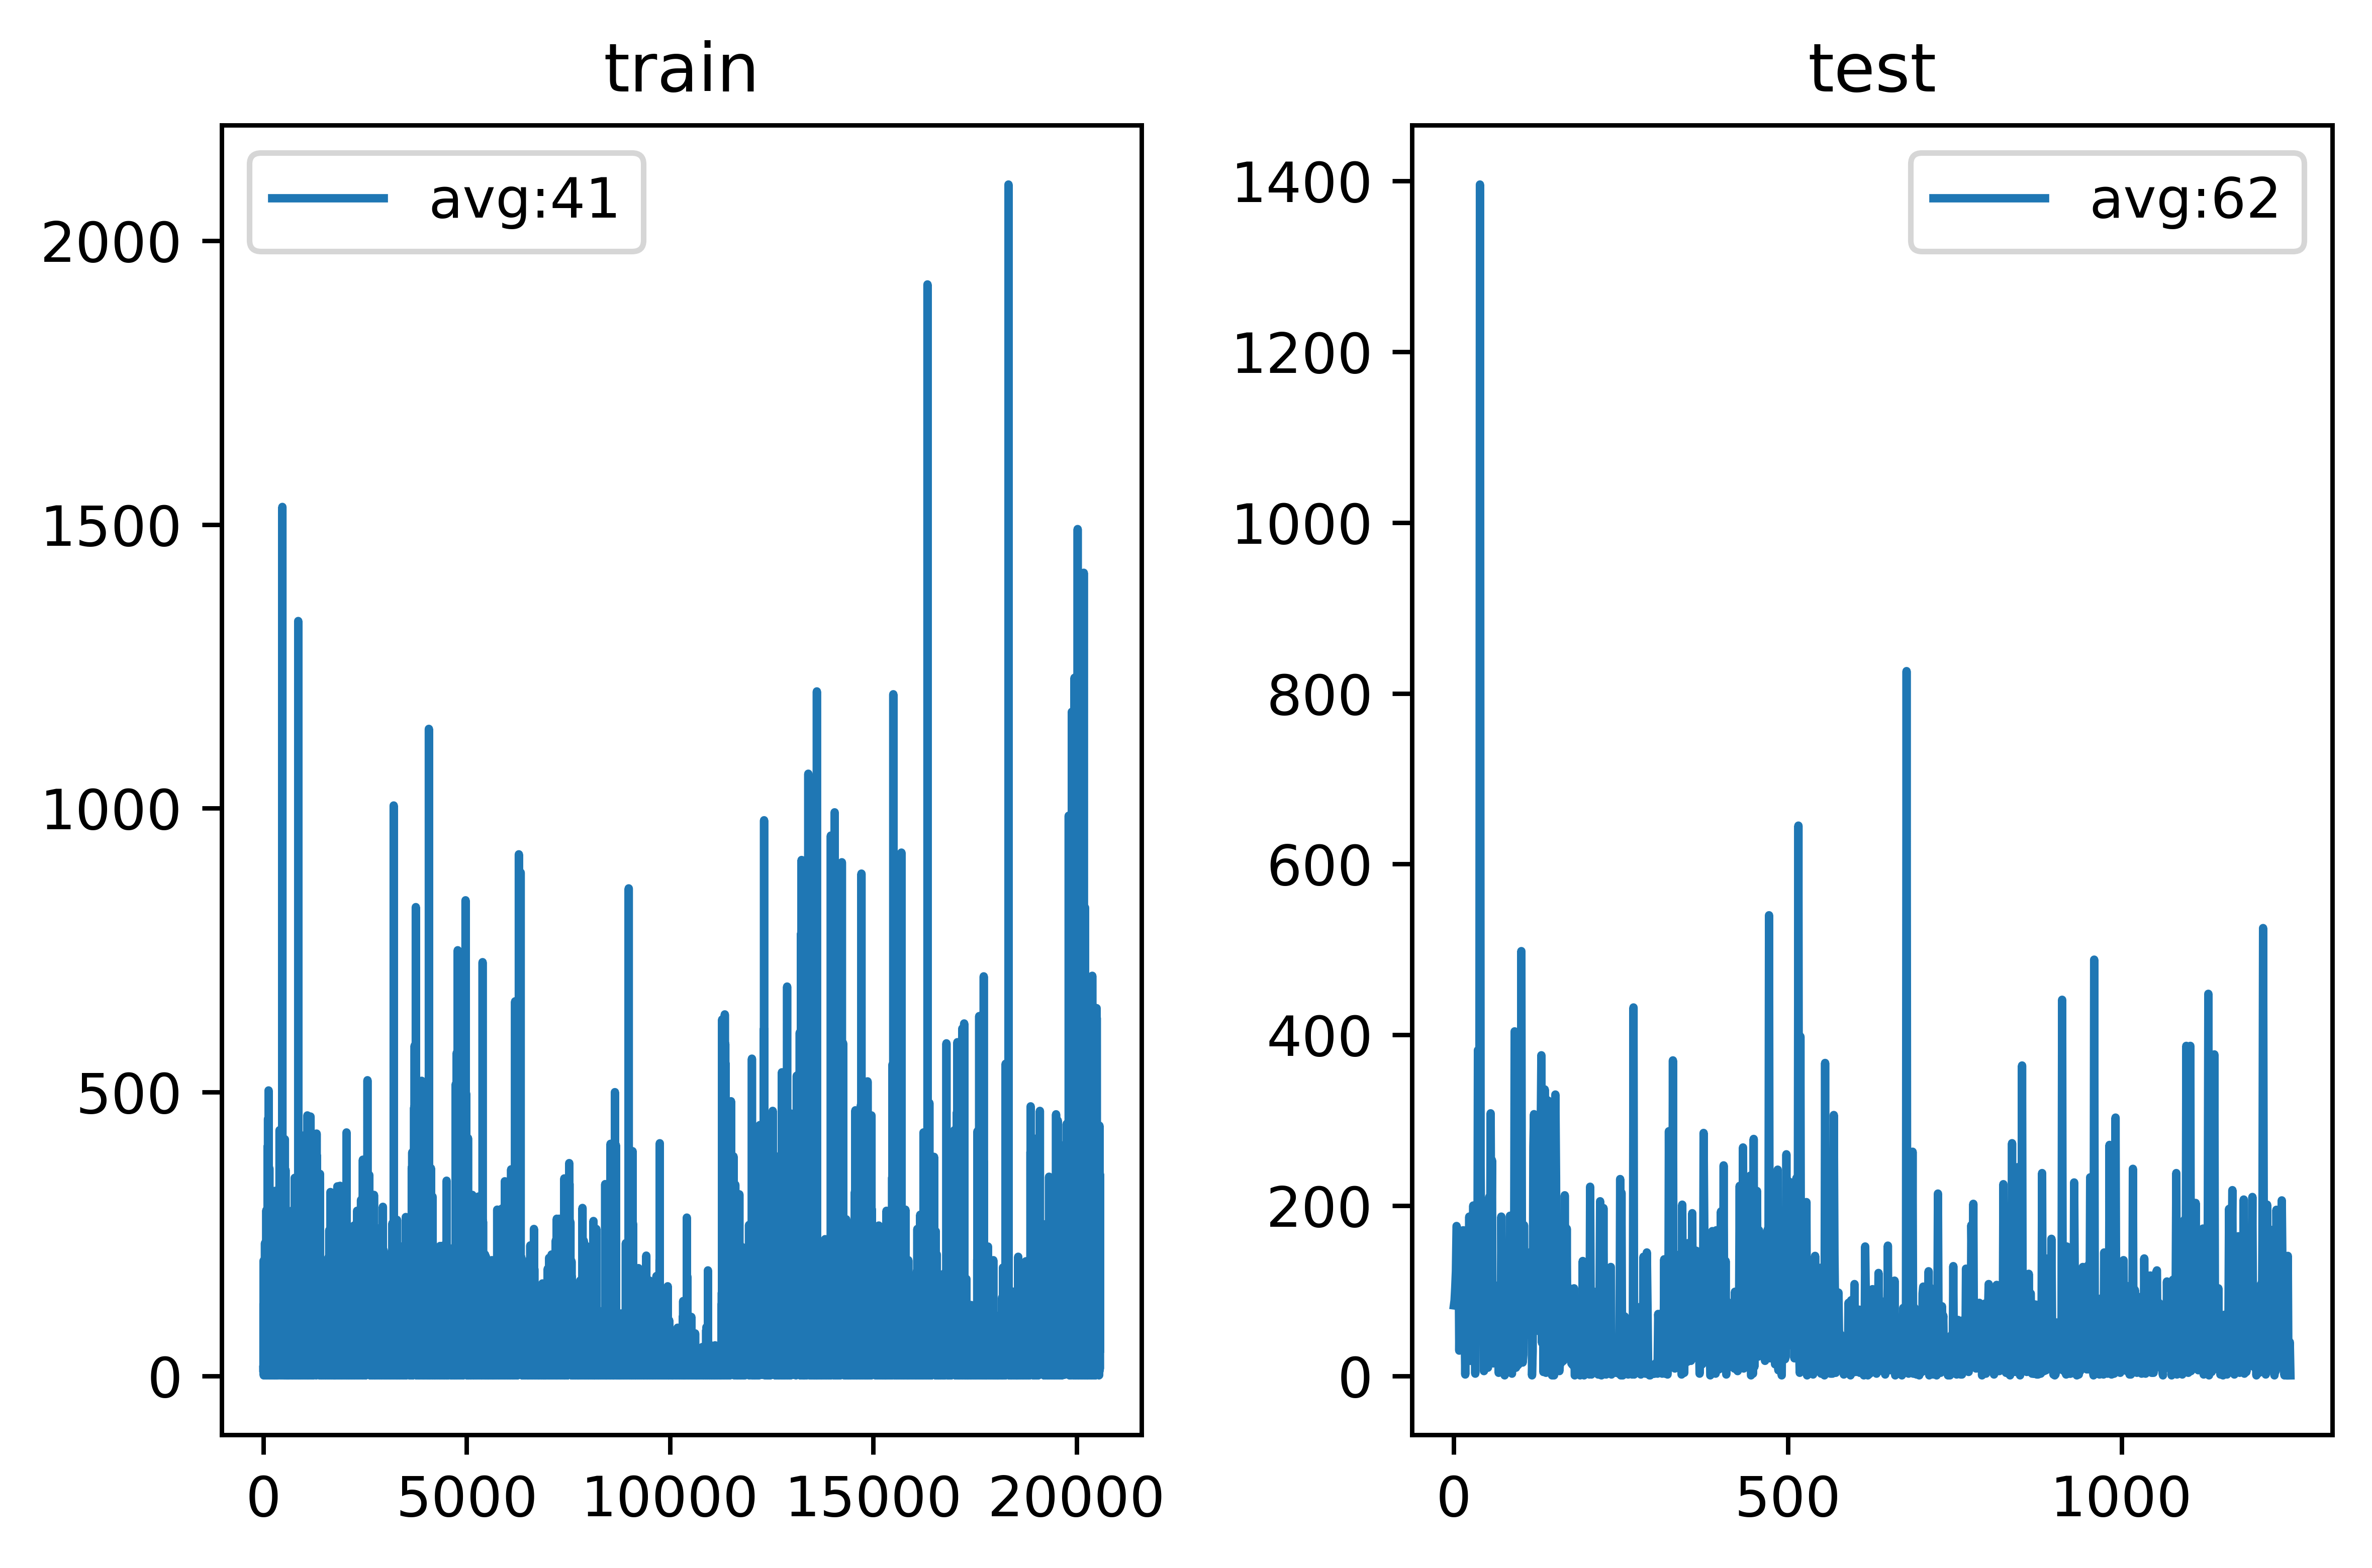

In [67]:
train_des = np.sum(book_user_train.values,axis = 0 )
test_des = np.sum(book_user_test.values, axis = 0)

fig = plt.figure(dpi=800)
plt.subplot(121)
plt.plot(
    list(i for i in range(book_user_train.shape[1])), 
    train_des, label=f"avg:{np.mean(train_des):.0f}"
)
plt.legend()
plt.title("train")

plt.subplot(122)
plt.plot(
    list(i for i in range(book_user_test.shape[1])), 
    test_des,label=f"avg:{np.mean(test_des):.0f}"
)
plt.legend()
plt.title("test")

plt.tight_layout()
plt.savefig(os.path.join(dataroot,"book","train_test_count.jpg"))


## Recommend

### Construct CF matrix
 
$$M_{\text{book}\times\text{train users}} \times M_{\text{train users}\times\text{course}}$$

In [ ]:
user_course_train = pd.read_csv(
    os.path.join(dataroot, "course","train.csv")
)
user_course_train['uid'] = user_course_train['uid'].astype(str)
print("train user course OK")


book_user_train = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_train.csv")
)
print("train book user Ok")

In [224]:
book_user_train_tensor = torch.tensor(
    book_user_train.values
)
print(book_user_train_tensor.size())

user_course_train_tensor = torch.tensor(
    (user_course_train.drop(columns=['uid'])).values
)
print(user_course_train_tensor.size())



torch.Size([1000, 20575])
torch.Size([20575, 7054])


In [227]:
book_course_tensor = torch.matmul(
    book_user_train_tensor.to(device=d),
    user_course_train_tensor.to(device=d)
).cpu()

print(book_course_tensor.size())


torch.Size([1000, 7054])


##### Write result for 3 type of file
torch tensor, numpy array, csv

In [233]:
torch.save(
    book_course_tensor, 
    os.path.join("result","CF","cf_book_course.pt")
)

In [228]:
book_course_matrix = book_course_tensor.numpy()

In [229]:
np.save(
    os.path.join("result","CF","cf_book_course"),
    book_course_matrix
)

In [ ]:
book_course_df = pd.DataFrame(
    columns=user_course_train.drop(columns=['uid']).columns,
    data=book_course_matrix
)
print(book_course_df.shape)
book_course_df.head()

In [10]:
book_course_df.to_csv(
    os.path.join("result","CF","cf_book_course.csv"),
    index = False
)

### Using naive CF

In [5]:
user_course_test = pd.read_csv(
    os.path.join(dataroot, "course", "test.csv")
)
user_course_test['uid'] = user_course_test['uid'].astype(str)
print("test user course OK")

user_course_test_matrix = (
    user_course_test.drop(columns = ['uid'])
).values



test user course OK
test book user Ok


#### Read the collaborative tabel 
$M_{\text{book}\times \text{course}}$

In [3]:
# If continuous executing this Note book from 
# the H1 label "Recommend"
# ,there is no needed to execute this cell

book_course_tensor= torch.load(
    os.path.join("result","CF","cf_book_course.pt")
)
book_course_tensor.size()

torch.Size([1000, 7054])

#### Collaborative filter to generate personal recommend list
Find the top K number of each prefix 3 book categories that counted from the other studensts who have had the same courses with the test student.

In [6]:
recommend_list = {}
for i in tqdm(range(user_course_test.shape[0])):
    uid = user_course_test.iloc[i]['uid']
    testi = user_course_test_matrix[i][:]
    itscourses = np.where(testi>0)
    cf = torch.sum(book_course_tensor[:, itscourses[0]],dim=1)
    ordered = torch.argsort(cf,descending=True)
    recommend_list[uid] = ordered.tolist()

100%|██████████| 1254/1254 [00:05<00:00, 218.42it/s]


In [7]:
with open(os.path.join("result","CF","recommend_list.json"),"w+") as rl:
    json.dump(recommend_list, rl, indent=4)


#### Evaluation (Precision Recall)

In [ ]:
book_user_test = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_test.csv")
)
print("test book user Ok")


In [248]:
# If continuous executing this Note book from 
# the H4 label 
# "Collaborative filter to generate personal recommend list"
# ,there is no needed to execute this cell

recommend_list = {}

with open(os.path.join("result", "CF", "recommend_list.json"),"r") as jf:
    recommend_list = json.load(jf)

In [8]:
def tostr(x):
    return str(x)
def top_K(topk):
    prediction = []
    gth = []
    for k, v in (recommend_list.items()):
        predi = v[:topk]
        predi = list(map(tostr, predi))
        gthi = book_user_test[k].values
        actual = np.where(gthi>0)[0].tolist()
        actual = list(map(tostr, actual))
    
        prediction.append(predi)
        gth.append(actual)
    
    prec = recmetrics.recommender_precision(prediction,gth)
    recall = recmetrics.recommender_recall(prediction, gth)

    return prec, recall

In [9]:
prec = []
recall = []
f1= []
max_topN = 100
for k in tqdm(range(1,max_topN+1)):
    metric = top_K(k)    
    prec.append(metric[0])
    recall.append(metric[1])
    f1.append(2/((1/metric[0])+(1/metric[1])))
f1_max = np.argmax(np.array(f1))


100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


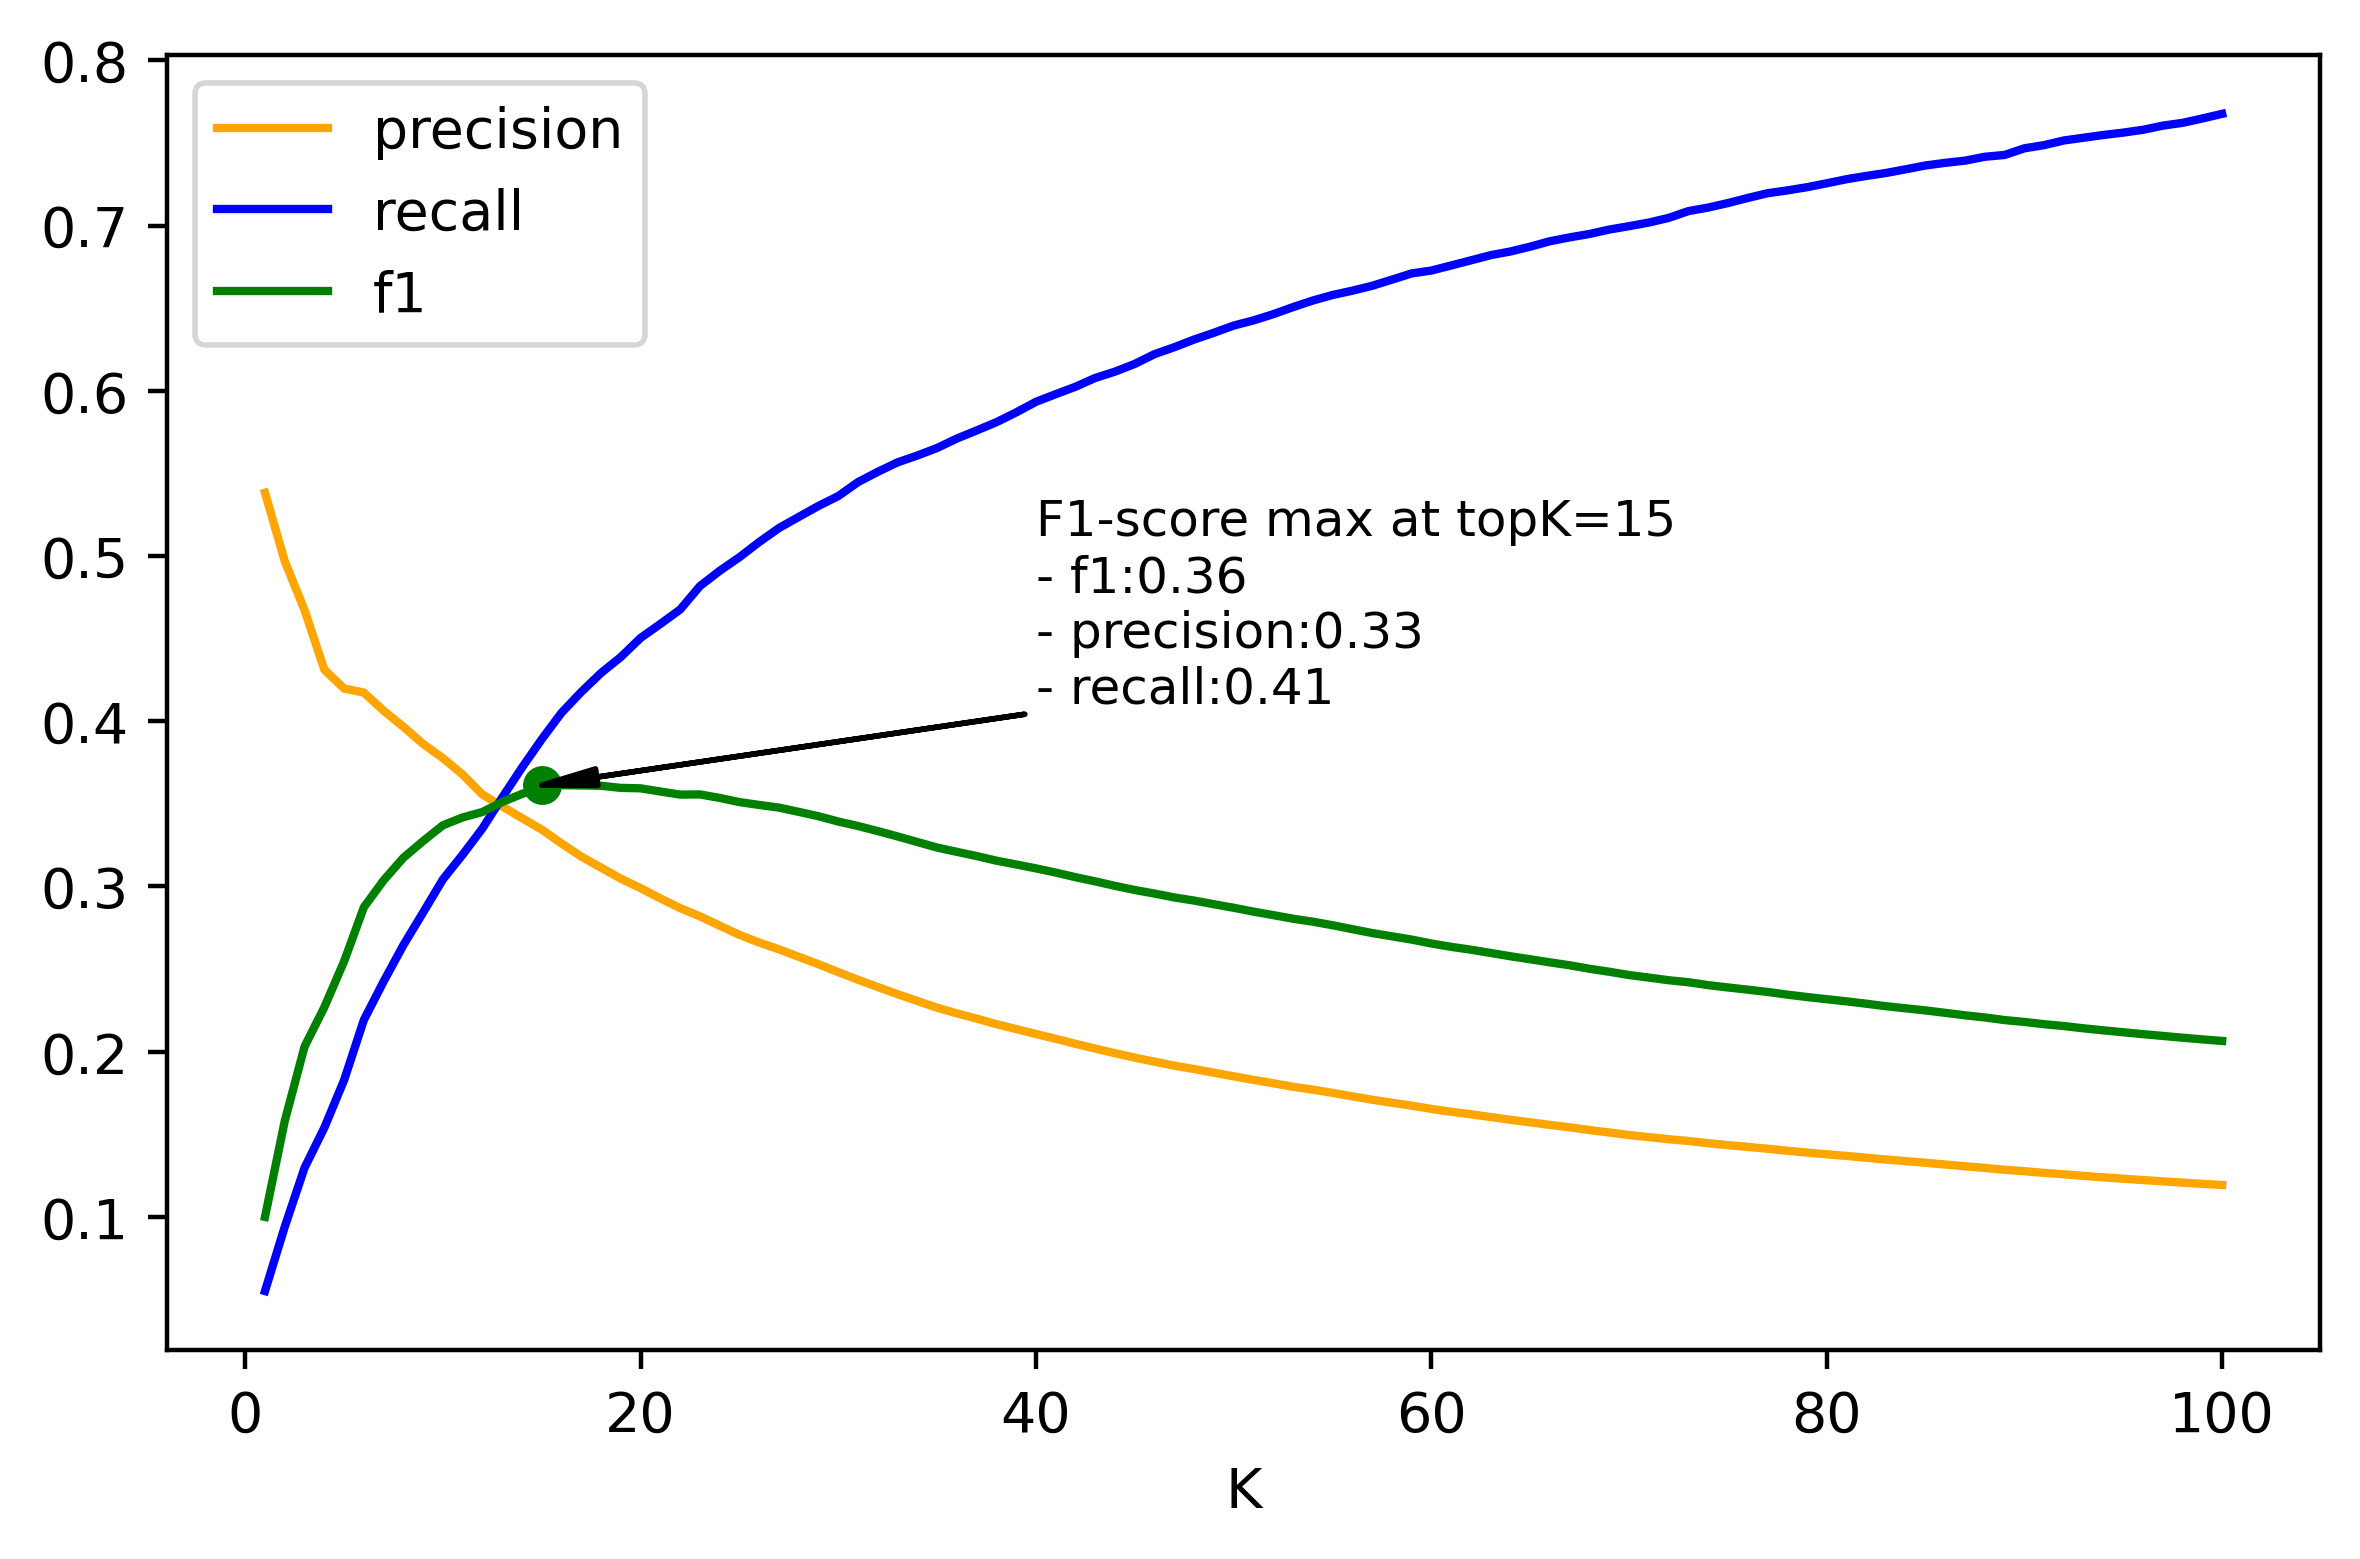

In [61]:
plt.figure(dpi=400)
plt.plot(
    list(k for k in range(1,max_topN+1)), 
    prec, 
    label = "precision",color="orange"
)
plt.plot(
    list(k for k in range(1,max_topN+1)),
    recall,
    label = "recall",color = "blue"
)
plt.plot(
    list(k for k in range(1,max_topN+1)),
    f1,
    label = "f1",color="green")
plt.scatter(f1_max, f1[f1_max], color="green")

f1_max_des = f"F1-score max at topK={f1_max}\n\
- f1:{f1[f1_max]:.2f}\n\
- precision:{prec[f1_max]:.2f}\n\
- recall:{recall[f1_max]:.2f}"

plt.annotate(
    text=f1_max_des, 
    xytext=(f1_max+25, f1[f1_max]+0.05),color="black",
    xy=(f1_max, f1[f1_max]),
    arrowprops={
        'width':0.01,
        'headlength':10,
        'headwidth':3,
        'facecolor':'#000',
        'shrink':0
    },
    fontsize=9
)

plt.xlabel("K")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("result","CF","metrics.jpg"))

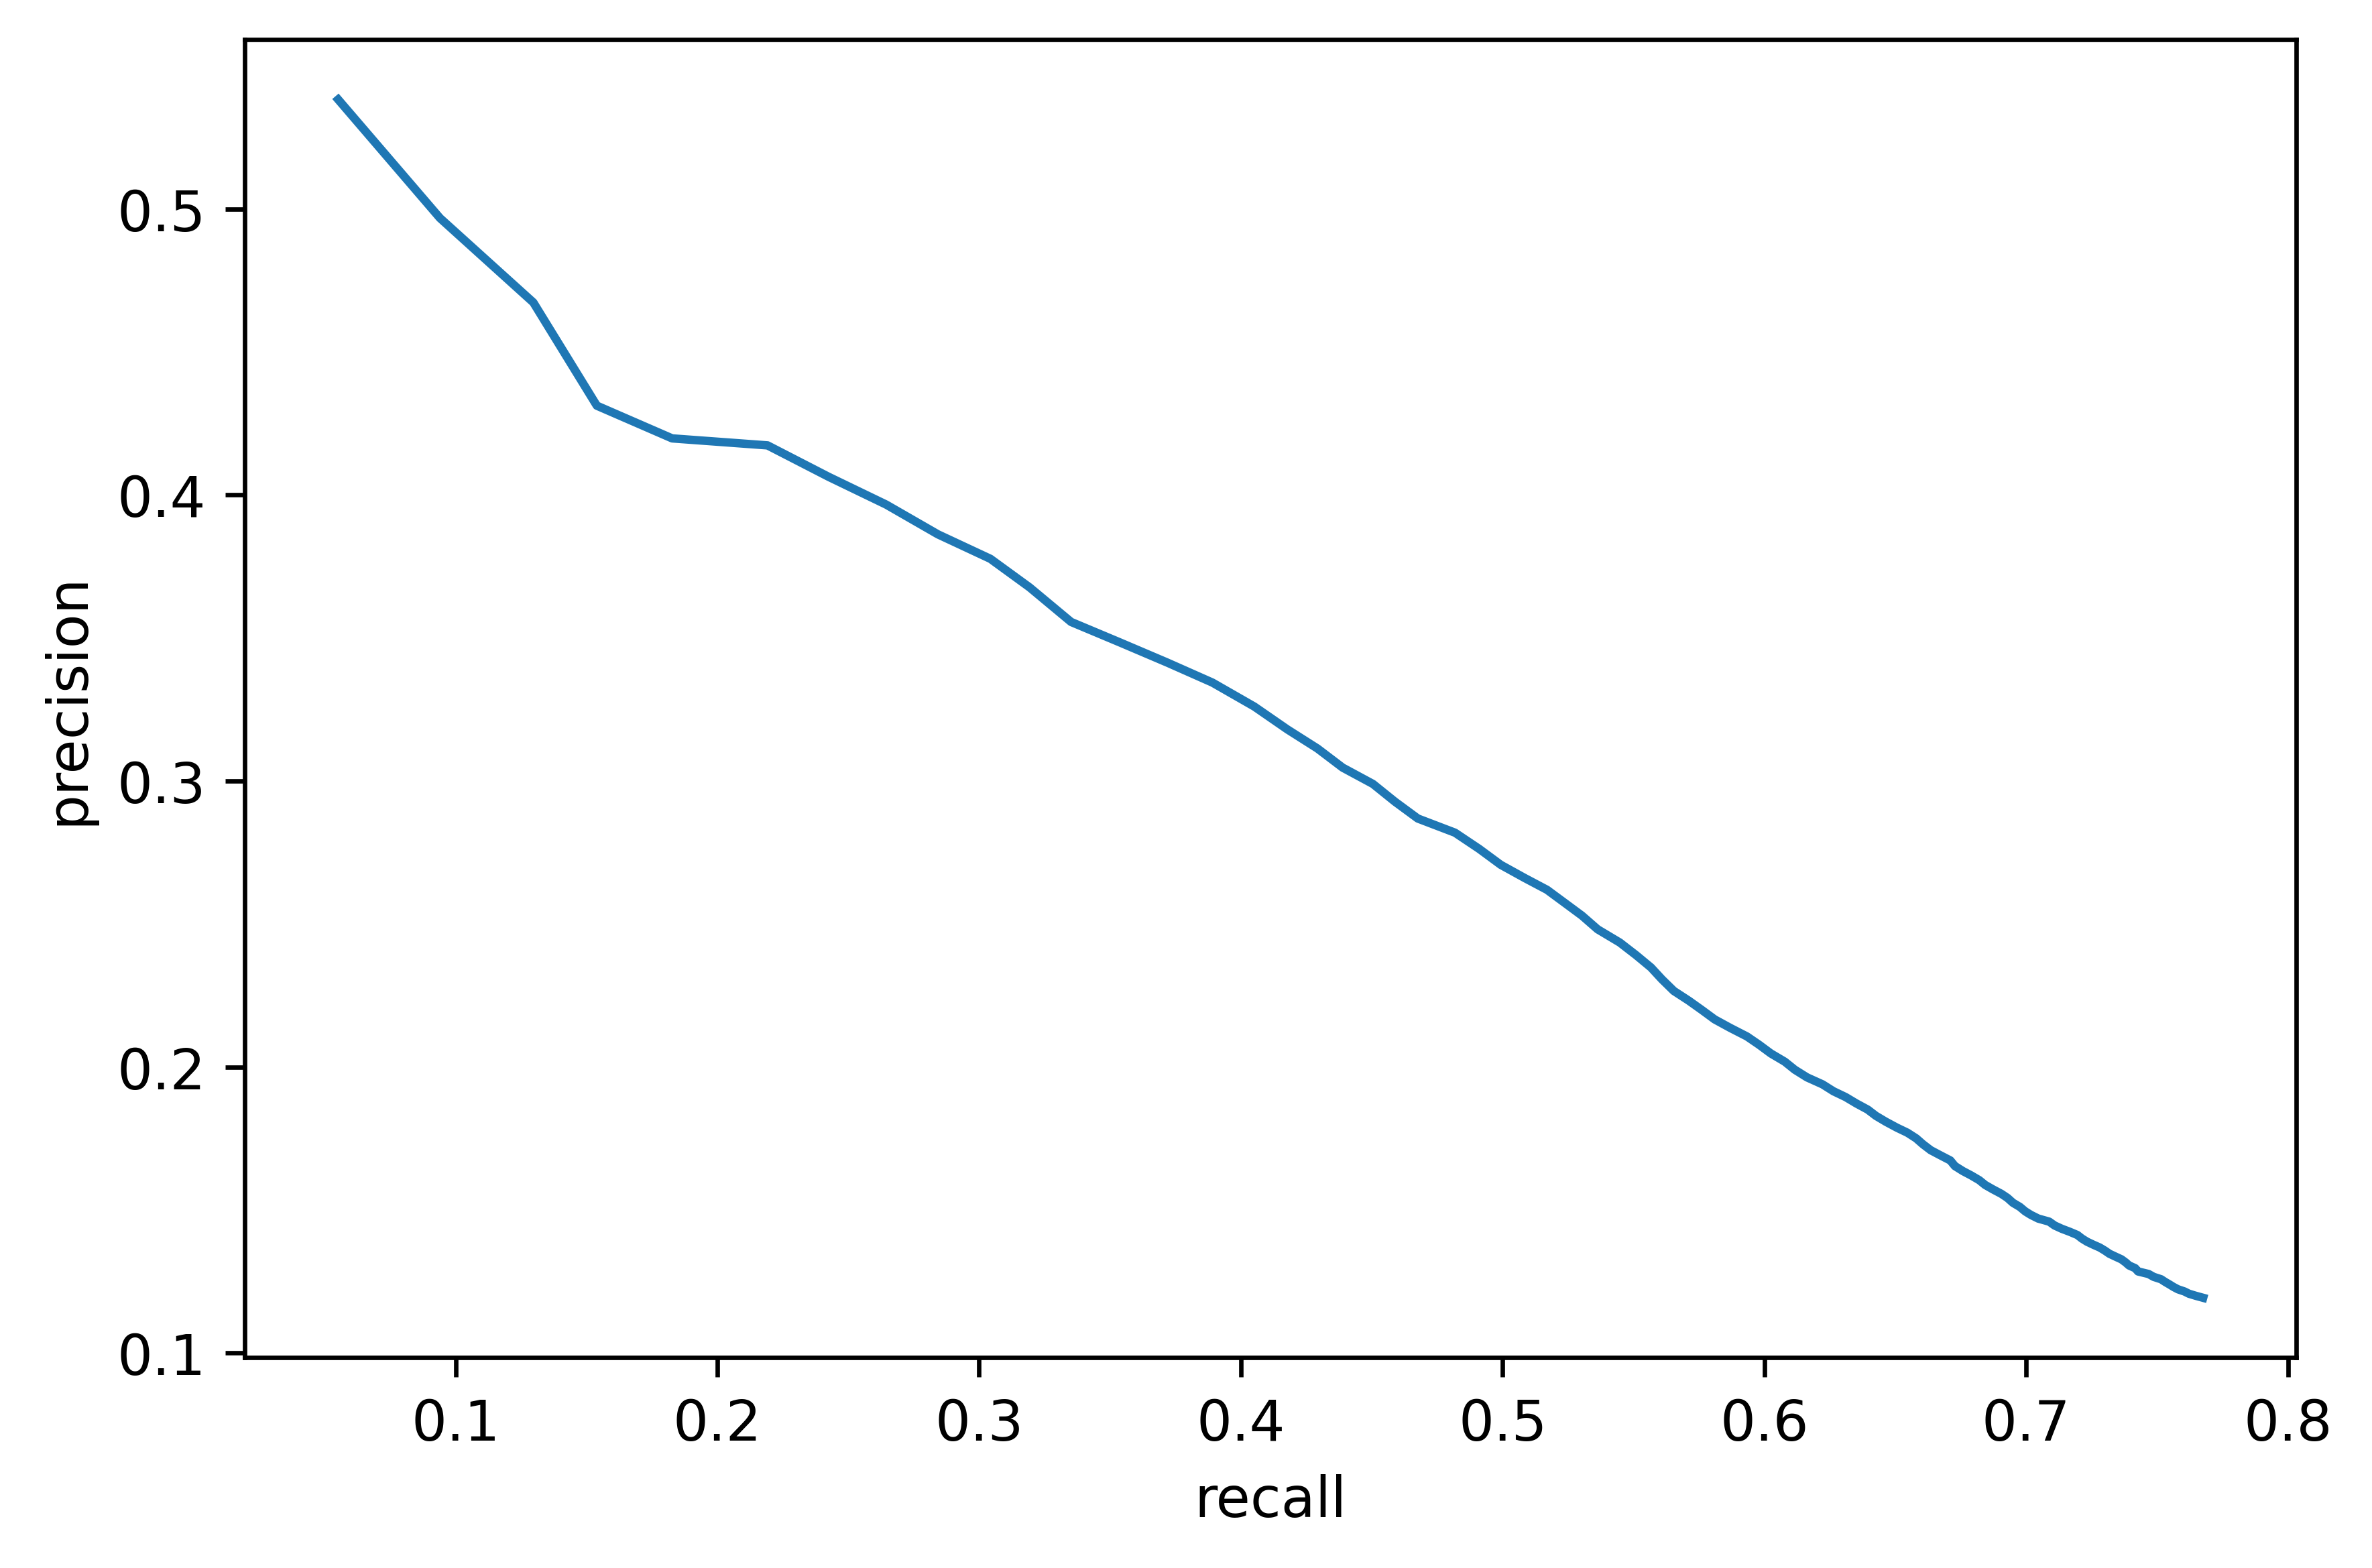

In [58]:
plt.figure(dpi=600)
plt.plot(recall,prec)
plt.ylabel("precision")
plt.xlabel("recall")
plt.tight_layout()
plt.savefig(os.path.join("result","CF","Pre_Re.jpg"))

### Using a strange CF (will fail w.h.p.)

In [12]:
def pairwise_cos_sim(arrx:np.ndarray):
    arrx_nor = normalize(arrx, axis=1)
    x = torch.tensor(arrx_nor).to(device=d)
    simtable = torch.zeros((x.size()[0], x.size()[0]))
    for i in range(x.size()[0]):
        simtable[i] = torch.sum(
            (x[i,:].expand(x.size()))*x,dim=1
        ).cpu()
    simtable = simtable.fill_diagonal_(0)
    return simtable

test_x = np.array(
    [[1,0,1],[0,1,0],[1,1,1]]
)
print(pairwise_cos_sim(test_x))
print(2/(6**(1/2)))

tensor([[0.0000, 0.0000, 0.8165],
        [0.0000, 0.0000, 0.5774],
        [0.8165, 0.5774, 0.0000]])
0.8164965809277261


#### Some searching data set up

In [13]:
courselist = []
with open(os.path.join(dataroot, "course","courselist.txt"),"r") as f:
    courselist= f.readlines()
    courselist = list(map(lambda x:x.strip(),courselist))


In [14]:
coursemap = {}
with open("course_map.json","r") as f:
    coursemap = json.load(f)

#### See most sim

In [15]:
def target(user):
    testuser1 = user_course_test.iloc[user]
    itcourse = np.where((testuser1.drop(['uid']).values)>0)[0]
    thisu = book_course_matrix[:, itcourse]
    simt = pairwise_cos_sim(arrx = thisu.T)
    mostsim= (simt==torch.max(simt)).nonzero()
    print(torch.max(simt))
    c1 = mostsim[0][0].item()
    c2 = mostsim[0][1].item()
    c1 = courselist[c1]
    c2 = courselist[c2]
    print(f"{coursemap[c1]}/{coursemap[c2]}")
    

In [16]:
for i in range(5):
    target(i)
    print("="*30)

tensor(0.9998)
音樂劇場的發展與變異/博物館學
tensor(0.9998)
劇場數位管理與實務（二）/音樂劇場的發展與變異
tensor(1.)
兒童文學/劇場管理與實務（二）
tensor(1.)
劇場管理與實務（一）/劇場管理與實務（二）
tensor(0.9998)
劇場數位管理與實務（二）/音樂劇場的發展與變異
